In [1]:
import os
import librosa
import matplotlib.pyplot as plt

In [2]:
def extract_audio_features(audio_path):
    y, sr = librosa.load(audio_path, res_type=None , sr=None, mono=False)
    duration = librosa.get_duration(y=y, sr=sr)
    channels = 'Mono' if y.ndim == 1 else 'Stereo'
    return {'Audio': audio_path,'Durata (s)': duration,'Canali': channels,'Frequenza di campionamento (Hz)': sr}

feature1 = extract_audio_features('Dataset/Target/Acoustic Harassment Devices/AHD_Airmar.wav')
print(feature1)

{'Audio': 'Dataset/Target/Acoustic Harassment Devices/AHD_Airmar.wav', 'Durata (s)': 6.501587301587302, 'Canali': 'Stereo', 'Frequenza di campionamento (Hz)': 44100}


In [3]:
# Nel caso in cui volessimo dividere la ricerca tra target e non target, basta fare due for separati e passare 
# trargetpath e non target path al posto di dataset
target_path = 'Dataset/Target'
non_target_path = 'Dataset/Non-Target'

# Lista per memorizzare i percorsi dei file audio
audio_files = []

# Scorrere ricorsivamente le cartelle nel dataset
for root, dirs, files in os.walk('Dataset'):
    for file in files:
        if file.endswith(('.wav')):
           audio_files.append(os.path.join(root, file))
audio_features = []
for file in audio_files:
    feature1 = extract_audio_features(file)
    audio_features.append(feature1)
     


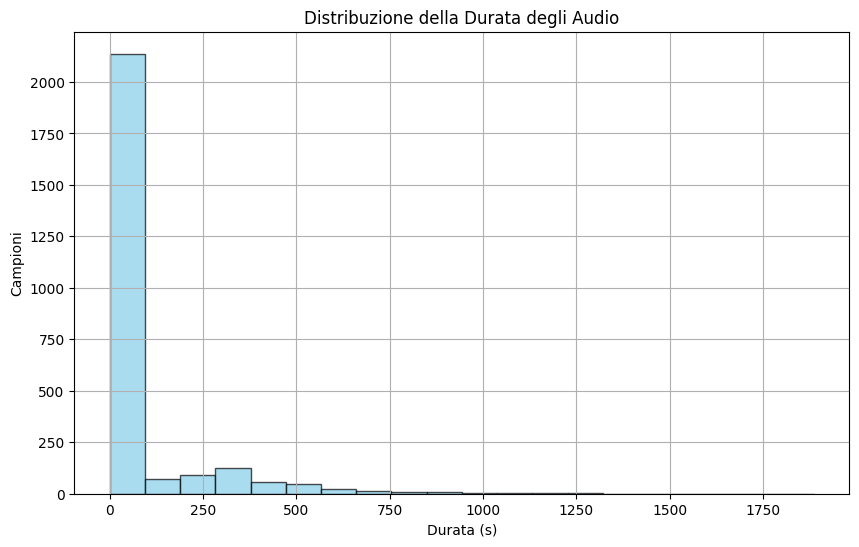

In [4]:
import matplotlib.pyplot as plt

durations = [feat['Durata (s)'] for feat in audio_features]

# Grafico della distribuzione della durata
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribuzione della Durata degli Audio')
plt.xlabel('Durata (s)')
plt.ylabel('Campioni')
plt.grid(True)
plt.show()

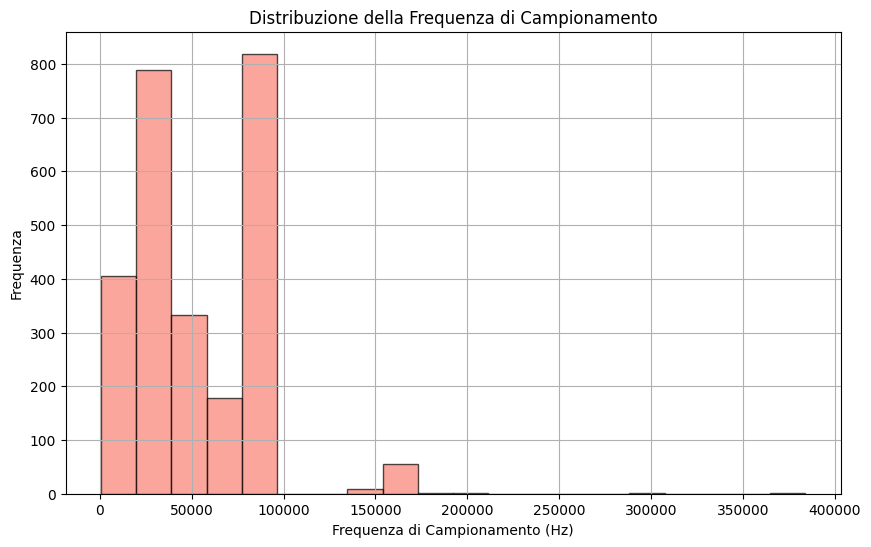

In [5]:
import matplotlib.pyplot as plt
#prova
frequencies = [feat['Frequenza di campionamento (Hz)'] for feat in audio_features]

# Grafico della distribuzione della frequenza di campionamento
plt.figure(figsize=(10, 6))
plt.hist(frequencies, bins=20, color='salmon', edgecolor='black', alpha=0.7)
plt.title('Distribuzione della Frequenza di Campionamento')
plt.xlabel('Frequenza di Campionamento (Hz)')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

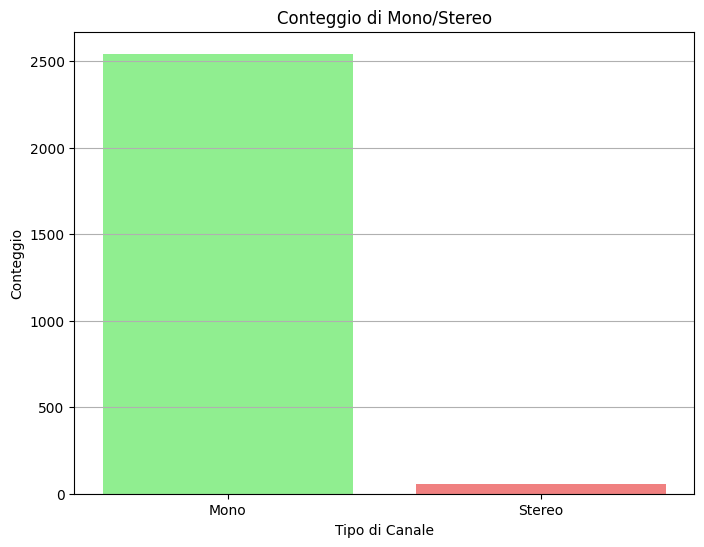

In [6]:
import matplotlib.pyplot as plt

channels = [feat['Canali'] for feat in audio_features]

# Grafico del conteggio di mono/stereo
plt.figure(figsize=(8, 6))
plt.bar(['Mono', 'Stereo'], [channels.count('Mono'), channels.count('Stereo')], color=['lightgreen', 'lightcoral'])
plt.title('Conteggio di Mono/Stereo')
plt.xlabel('Tipo di Canale')
plt.ylabel('Conteggio')
plt.grid(axis='y')
plt.show()